In [1]:
import platform
import sys
import datetime
import netCDF4
import numpy as np
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.TC_like as hTCL
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
import matplotlib.pyplot as plt
importlib.reload(hTCL);
importlib.reload(hGrid);
importlib.reload(hPlot);
importlib.reload(hData);

import warnings
warnings.filterwarnings("ignore")
# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

### 1. Load resampled data, select time-period, and convert ASCAT SWI to VSM. 

### 1.1. Stduy domain

In [2]:
domain_lon, domain_lat = hGrid.generate_lon_lat_eqdgrid(0.25)
domain_lon = domain_lon[:600]
domain_lat = domain_lat[:600]

### 1.2. Specify the time-period.

In [3]:
start_date = datetime.datetime(2022, 4, 1)
end_date   = datetime.datetime(2022, 7, 31)

# Calculate the day of year values
doy1 = start_date.timetuple().tm_yday
doy2 = end_date.timetuple().tm_yday

In [6]:
m, n = domain_lon.shape; z = doy2-doy1+1

path_list = ['am', 'pm']
#combined the am and pm data sets
ASCAT_SM_am_pm = np.zeros((m, n, z*2), dtype='float64')
SMOS_SM_am_pm  = np.zeros((m, n, z*2), dtype='float64')
A2_SM_am_pm = np.zeros((m, n, z*2), dtype='float64')

for path in path_list:
    print(path)
    nc_file_SMOS  = nc_save_dir+'/SMOS_IC_2022_'+path+'_R_Noah_025.nc'
    nc_file_ASCAT = nc_save_dir+'/ASCAT_TUW_2022_2022_'+path+'_R_Noah_025.nc'
    nc_file_A2    = nc_save_dir+'/AMSR2_LPRM_2022_'+path+'_R_Noah_025.nc'

    nc_data_SMOS = netCDF4.Dataset(nc_file_SMOS)
    SMOS_SM      = nc_data_SMOS.variables['Resampled_SMOS_SM_QC'][:].data
    sub_SMOS_SM  = SMOS_SM[:,:, doy1:doy2+1]

    nc_data_ASCAT = netCDF4.Dataset(nc_file_ASCAT)
    ASCAT_SM      = nc_data_ASCAT.variables['Resampled_ASCAT_SM_gldas_QC'][:].data # Resampled_ASCAT_SM_gldas
                                                                                   # Resampled_ASCAT_SM_gldas_QC
                                                                                   # Resampled_ASCAT_SM_hwsd
                                                                                   # Resampled_ASCAT_SM_hwsd_QC
    sub_ASCAT_SM  = ASCAT_SM[:600,:, doy1:doy2+1]/100
    
    nc_data_A2 = netCDF4.Dataset(nc_file_A2)
    A2_SM      = nc_data_A2.variables['Resampled_A2_SM_x_QC'][:].data
    sub_A2_SM  = A2_SM[:,:, doy1:doy2+1]

    if path == 'am':
        SMOS_SM_am_pm[:, :,  ::2]  = sub_SMOS_SM
        ASCAT_SM_am_pm[:, :, ::2]  = sub_ASCAT_SM
        A2_SM_am_pm[:, :, ::2]     = sub_A2_SM
    else:
        SMOS_SM_am_pm[:, :, 1::2]  = sub_SMOS_SM
        ASCAT_SM_am_pm[:, :, 1::2] = sub_ASCAT_SM
        A2_SM_am_pm[:, :, 1::2]    = sub_A2_SM

am
pm


In [42]:
ma_SMOS_SM_am_pm  = hData.moving_average_3d(SMOS_SM_am_pm, 15)
ma_ASCAT_SM_am_pm = hData.moving_average_3d(ASCAT_SM_am_pm, 15)
ma_A2_SM_am_pm    = hData.moving_average_3d(A2_SM_am_pm, 15)

# pseudo DA_SM data. Generated from the ASCAT SM data with white noise.
#temp_error = np.random.normal(loc=0, scale=0.05, size=(m, n, z*2))
#DA_SM      = ASCAT_SM_am_pm + temp_error
#ma_DA_SM   = hData.moving_average_3d(DA_SM, 15)

Calculating moving average: 100%|█████████████| 244/244 [00:57<00:00,  4.26it/s]


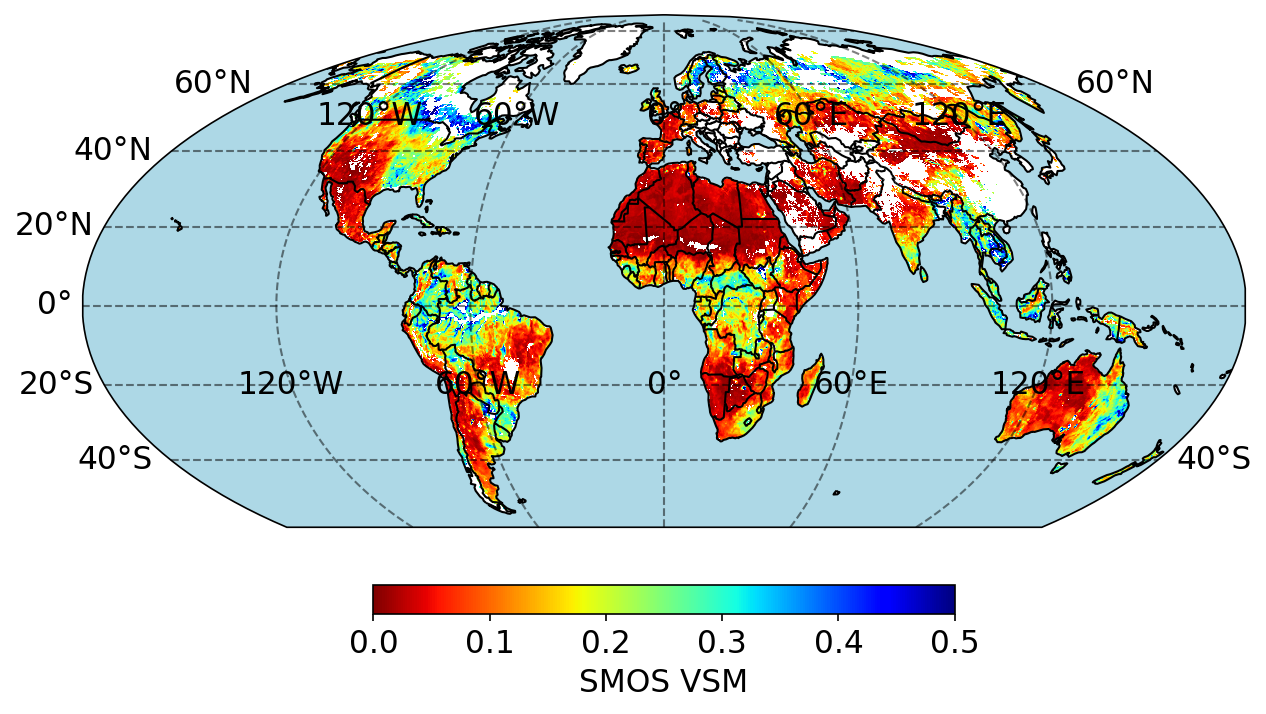

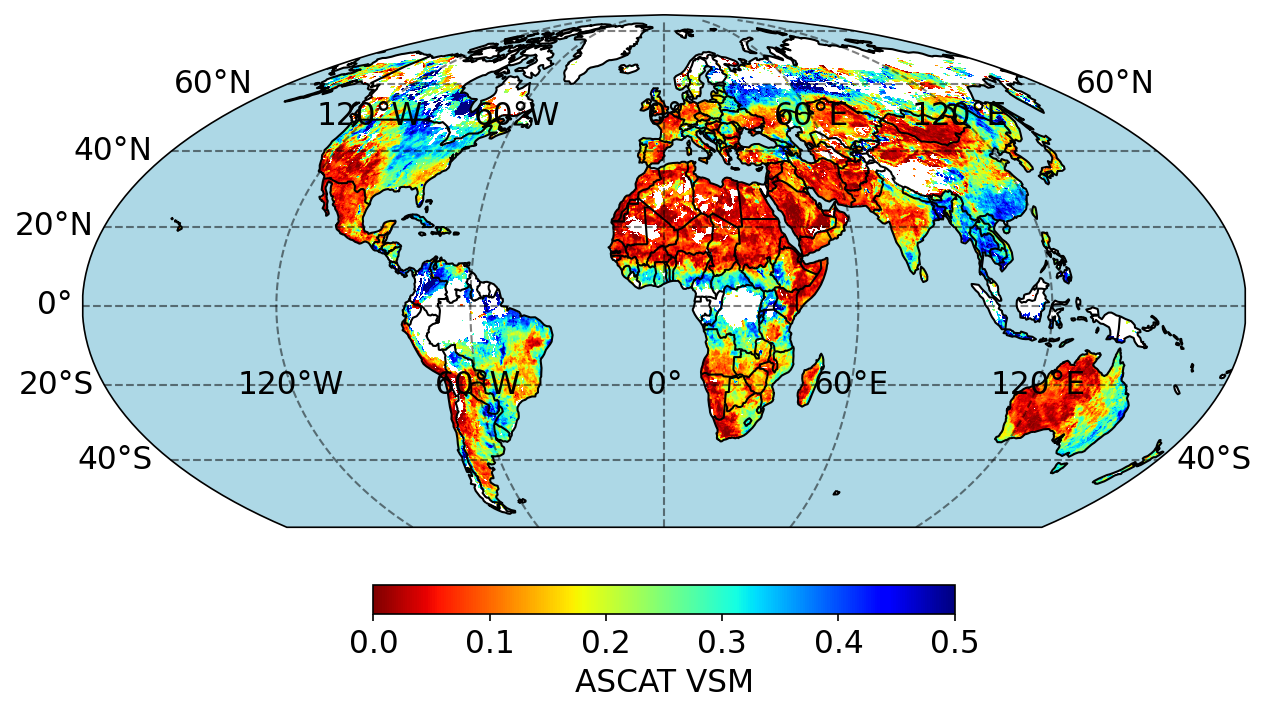

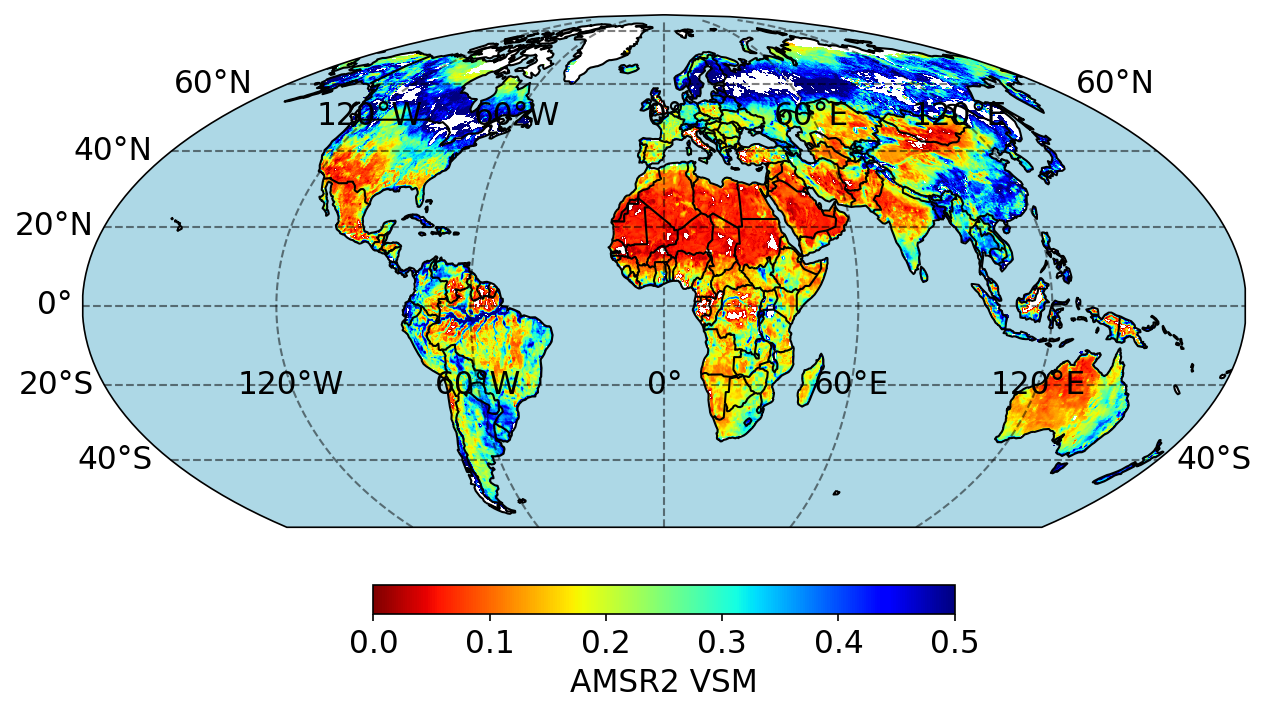

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [71]:
temp_doy = 100
target = ma_SMOS_SM_am_pm
hPlot.plot_map(domain_lon, domain_lat, target[:,:,temp_doy], 0, 0.5, plot_title='SMOS SM', label_title='SMOS VSM', cmap='jet_r', projection='Mollweide')
target = ma_ASCAT_SM_am_pm
hPlot.plot_map(domain_lon, domain_lat, target[:,:,temp_doy], 0, 0.5, plot_title='ASCAT SM', label_title='ASCAT VSM', cmap='jet_r', projection='Mollweide')
target = ma_A2_SM_am_pm
hPlot.plot_map(domain_lon, domain_lat, target[:,:,temp_doy], 0, 0.5, plot_title='AMSR2 SM', label_title='AMSR2 VSM', cmap='jet_r', projection='Mollweide')

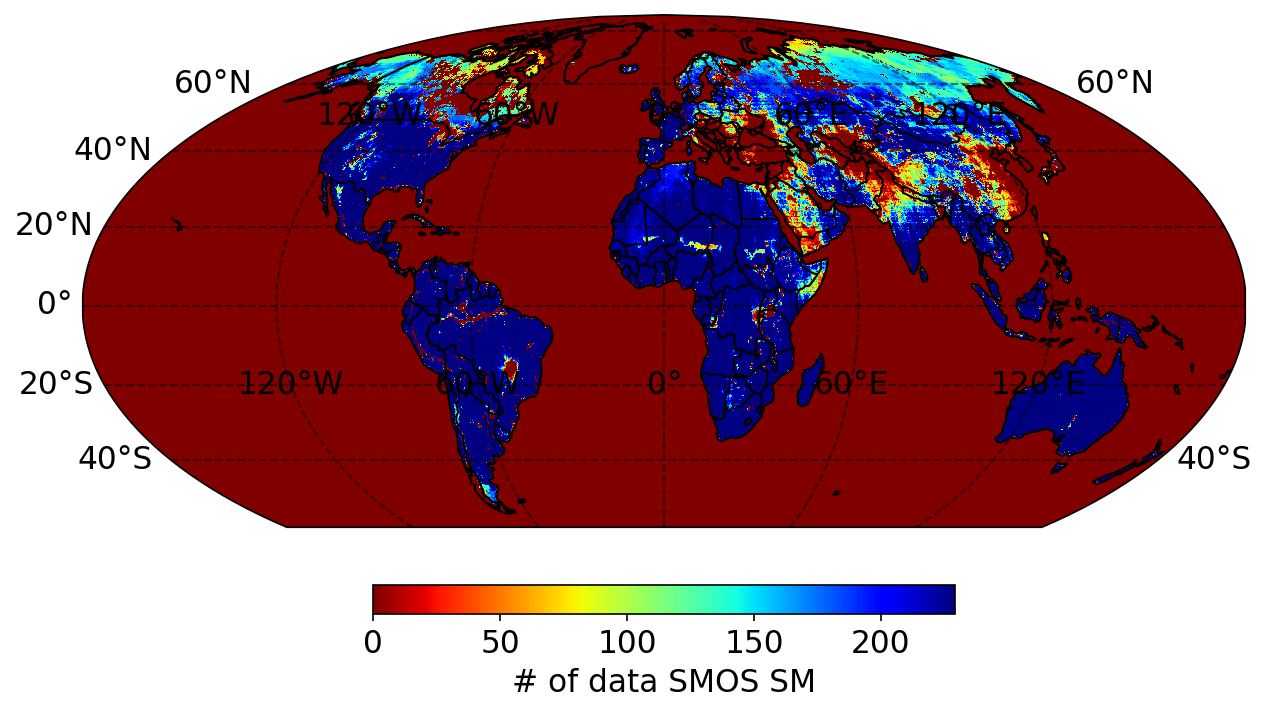

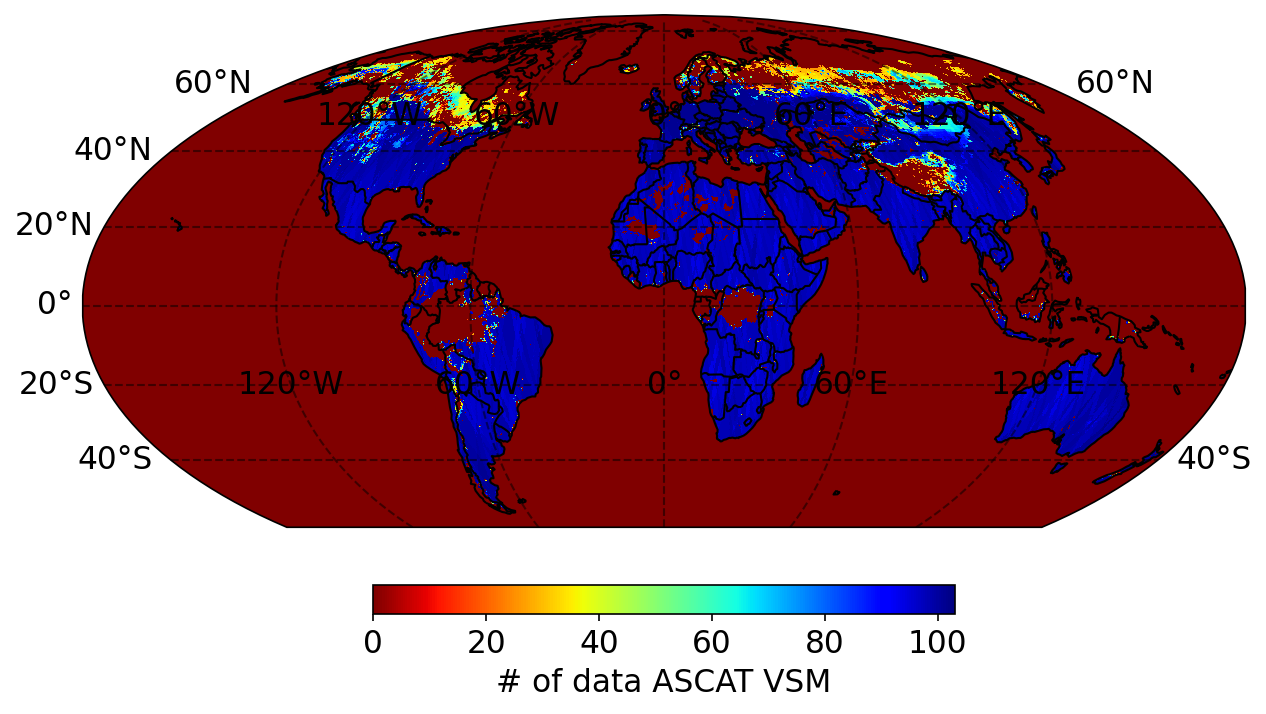

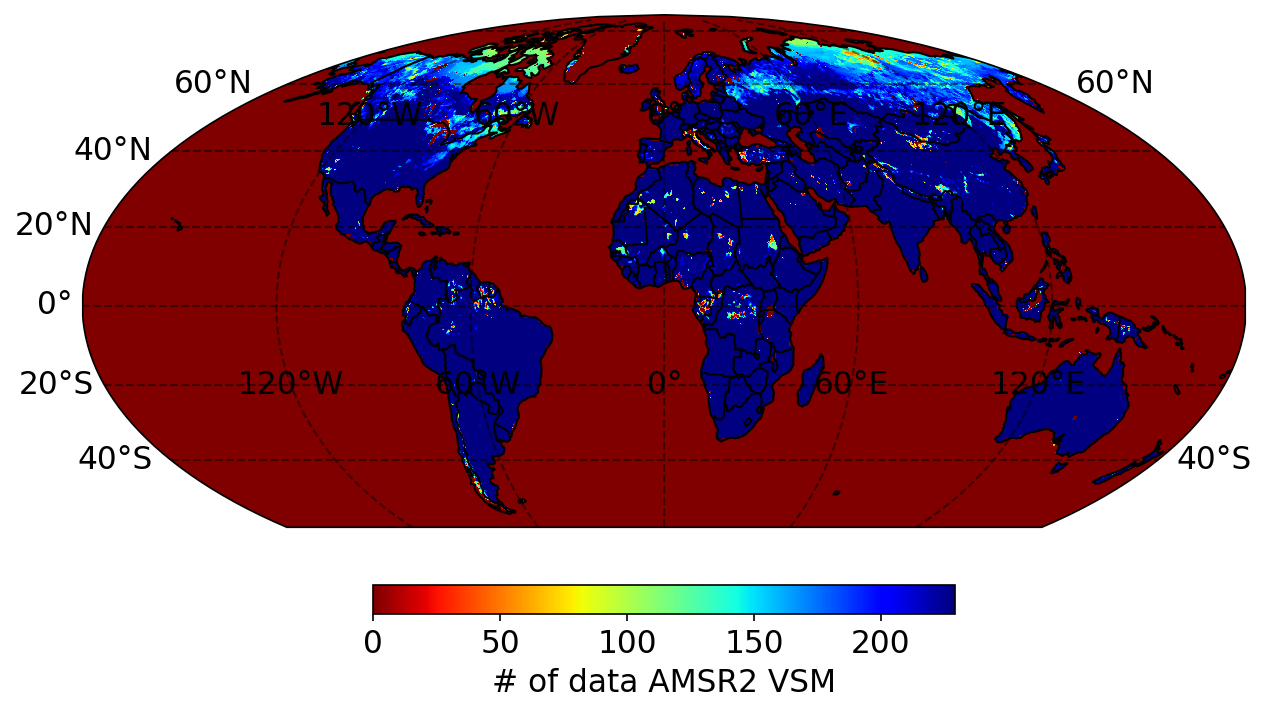

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [50]:
temp_doy = 100
target = ma_SMOS_SM_am_pm
target = np.sum(~np.isnan(target), axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, np.max(target), plot_title='# of data SMOS SM', label_title='# of data SMOS SM', cmap='jet_r', projection='Mollweide')
target = ma_ASCAT_SM_am_pm
target = np.sum(~np.isnan(target), axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, np.max(target), plot_title='# of data ASCAT SM', label_title='# of data ASCAT VSM', cmap='jet_r', projection='Mollweide')
target = ma_A2_SM_am_pm
target = np.sum(~np.isnan(target), axis=2)
hPlot.plot_map(domain_lon, domain_lat, target, 0, np.max(target), plot_title='# of data AMSR2 SM', label_title='# of data AMSR2 VSM', cmap='jet_r', projection='Mollweide')

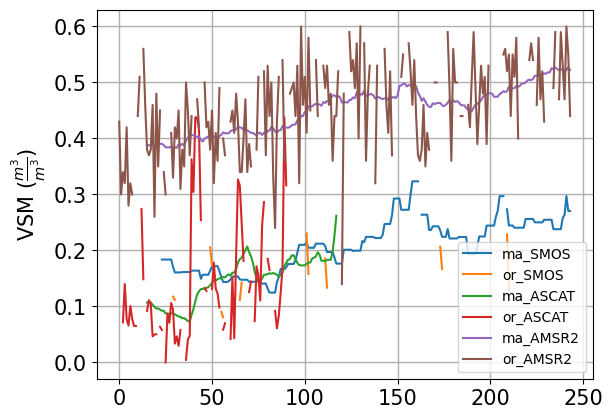

In [69]:
# Check the moving-averaged SM vs originia SM data sets
target = ma_ASCAT_SM_am_pm
target = np.sum(~np.isnan(target), axis=2)
idx = np.argwhere(np.max(target) == target)
i=0
plt.plot(ma_SMOS_SM_am_pm[idx[i][0], idx[i][1],:], label='ma_SMOS')
plt.plot(SMOS_SM_am_pm[idx[i][0], idx[i][1],:],label='or_SMOS')

plt.plot(ma_ASCAT_SM_am_pm[idx[i][0], idx[i][1],:],label='ma_ASCAT')
plt.plot(ASCAT_SM_am_pm[idx[i][0], idx[i][1],:], label='or_ASCAT')

plt.plot(ma_A2_SM_am_pm[idx[i][0], idx[i][1],:],label='ma_AMSR2')
plt.plot(A2_SM_am_pm[idx[i][0], idx[i][1],:], label='or_AMSR2')

plt.legend()
plt.grid()
plt.ylabel(r'VSM ($\frac{m^3}{m^3}$)');

### 1.3 Calcuate the TC numbers

In [32]:
D1 = ma_SMOS_SM_am_pm
D2 = ma_ASCAT_SM_am_pm
D3 = ma_A2_SM_am_pm
fMSE = TCL.TCA(D1, D2, D3, nod_th=20, corr_th=0.1, REF=None)[4]

### 1.4 Check the results

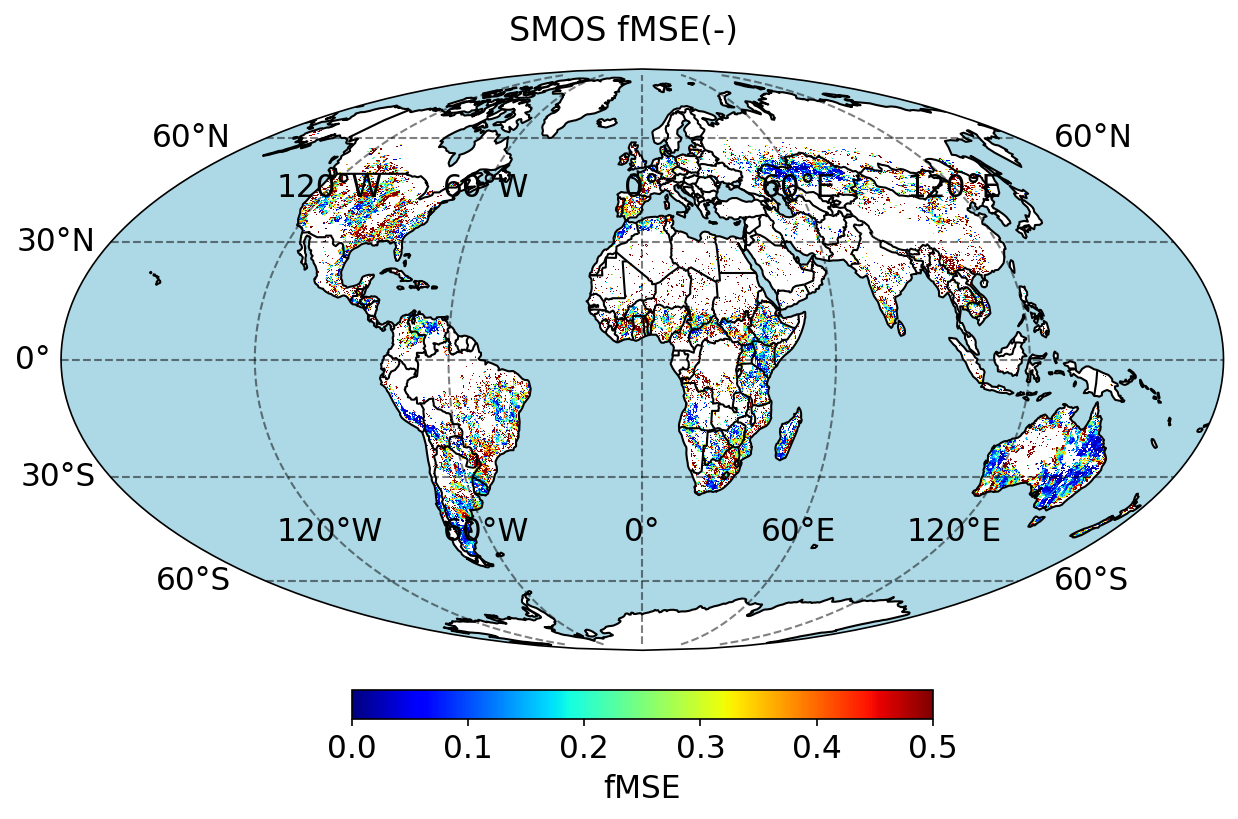

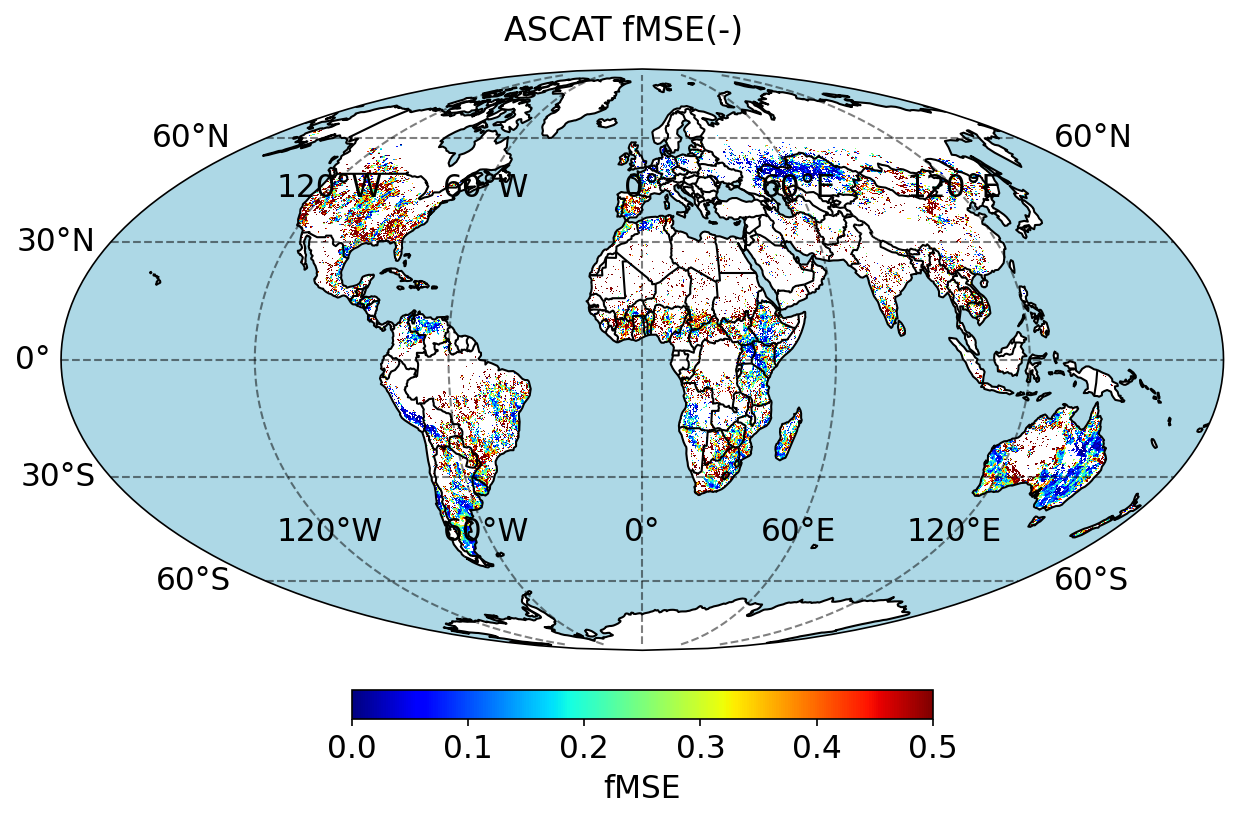

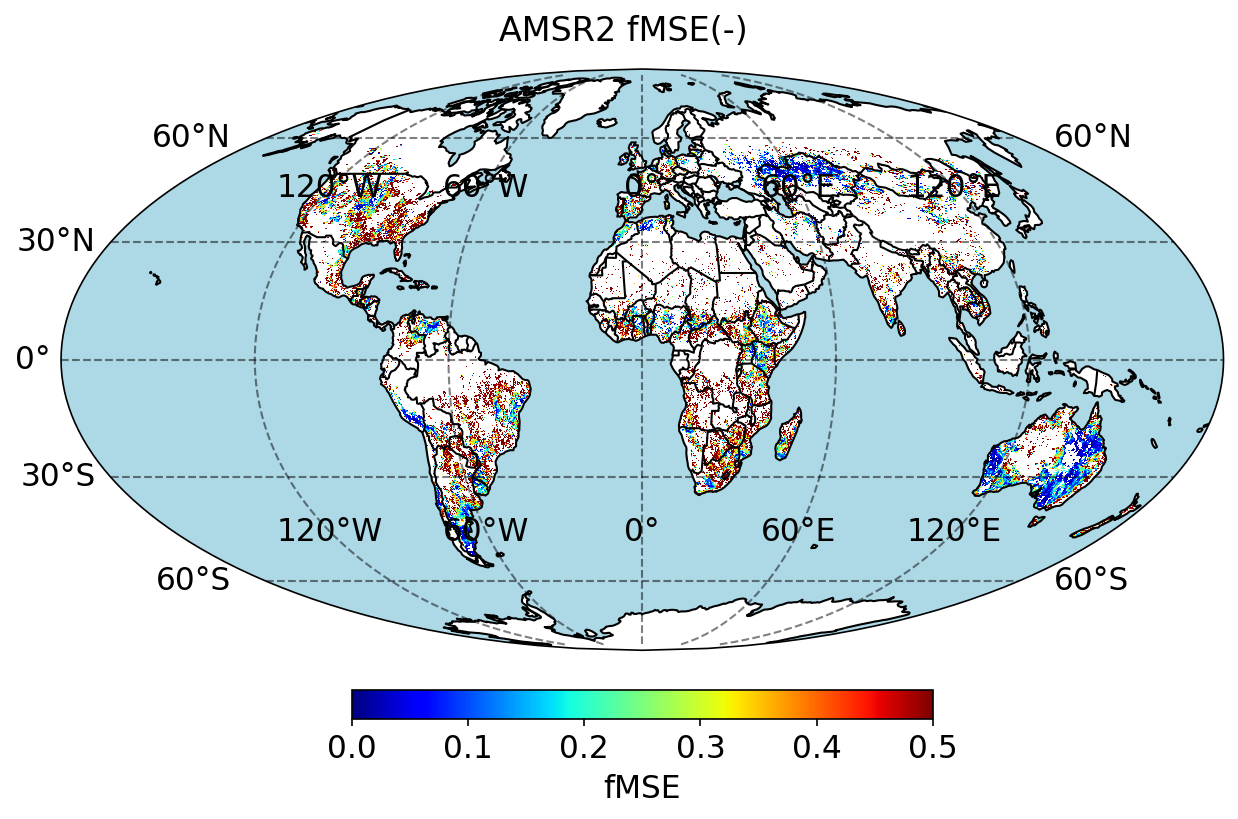

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [35]:
SMOS_fMSE  = fMSE['x'] #the lower the better
ASCAT_fMSE = fMSE['y'] #the lower the better
A2_fMSE    = fMSE['z'] #the lower the better

Plot.plot_map(domain_lon, domain_lat, SMOS_fMSE, 0, 0.5, plot_title='SMOS fMSE(-)', label_title='fMSE', cmap='jet', projection='Mollweide')
Plot.plot_map(domain_lon, domain_lat, ASCAT_fMSE, 0, 0.5, plot_title='ASCAT fMSE(-)', label_title='fMSE', cmap='jet', projection='Mollweide')
Plot.plot_map(domain_lon, domain_lat, A2_fMSE, 0, 0.5, plot_title='AMSR2 fMSE(-)', label_title='fMSE', cmap='jet', projection='Mollweide')